In [1]:
import torch.nn.functional as f
import torch
import numpy as np
import skvideo.io
import math
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
%matplotlib notebook

In [41]:
BATCH_SIZE = 3

In [78]:
class ToSpaceBGR(object):

    def __init__(self, is_bgr):
        self.is_bgr = is_bgr

    def __call__(self, tensor):
        if self.is_bgr:
            new_tensor = tensor.clone()
            new_tensor[0] = tensor[2]
            new_tensor[2] = tensor[0]
            tensor = new_tensor
        return tensor


class ToRange255(object):

    def __init__(self, is_255):
        self.is_255 = is_255

    def __call__(self, tensor):
        if self.is_255:
            tensor.mul_(255)
        return tensor

def plt_tensor(batched_t):
    showing = batched_t[0]
    if batched_t.shape[-1] == 3:
        showing = showing.detach().cpu().numpy()
    else:
        showing = showing.permute(1, 2, 0).detach().cpu().numpy()

    plt.imshow(showing)
    plt.show()

def plt_collate_batch(batched_t):
    n_col = 2
    n_rows = np.max([2, int(len(batched_t) / n_col)])
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_col, sharey=True, sharex=True)
    
    k = 0
    for i in range(n_rows):
        for j in range(n_col):
            print(k)
            if (k >= len(batched_t)):
                showing = torch.from_numpy(np.zeros(batched_t[0].shape))
            else:
                showing = batched_t[k]
                
            if batched_t.shape[-1] == 3:
                showing = showing.detach().cpu().numpy()
            else:
                showing = showing.permute(1, 2, 0).detach().cpu().numpy()

            axes[i, j].imshow(showing)
            k += 1

    plt.tight_layout()
    plt.show()

In [79]:
frames = skvideo.io.vread("/media/wgar/WD_Passport_4TB1/dataset/MSVD/YouTubeClips/AJJ-iQkbRNE_97_109.avi")
print(len(frames))
frames = frames[0:BATCH_SIZE]

288


<IPython.core.display.Javascript object>


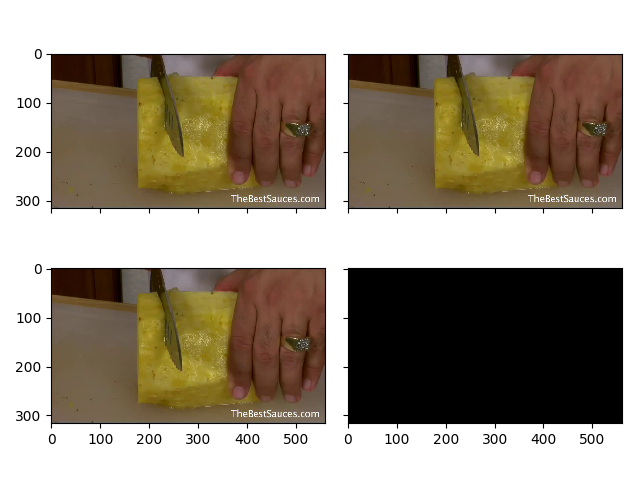

0
1
2
3


In [80]:
original = torch.tensor(frames)
pass_in = (original.float()).cuda()

plt_collate_batch(pass_in / 255.)

<IPython.core.display.Javascript object>


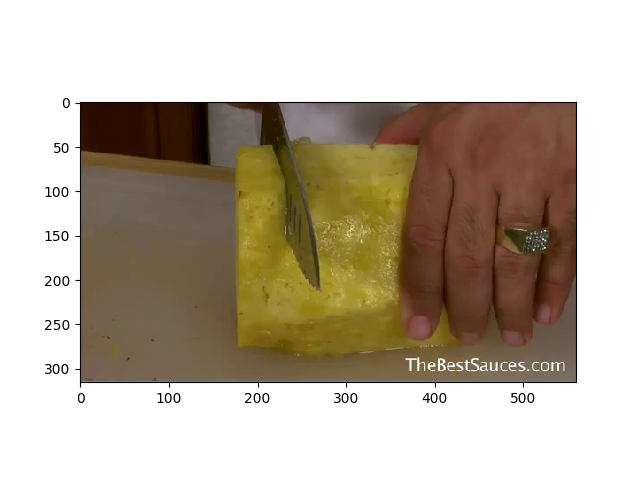

In [180]:
pass_in = torch.clamp(pass_in, min=0, max =255)
plt_tensor(pass_in / 255.)

In [181]:
frames_to_do = pass_in
n = frames_to_do.shape[0]
h, w = frames_to_do.shape[1:3]
scale = 0.875
input_size = [3, 331, 331]
mean, std = [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]
input_range = [0,1.]
input_space='RGB'
expand_size = int(math.floor(max(input_size) / scale))
if w < h:
    ow = expand_size
    oh = int(expand_size * h / w)
else:
    oh = expand_size
    ow = int(expand_size * w / h)

tfs = []
tfs.append(ToSpaceBGR(input_space == 'BGR'))
tfs.append(ToRange255(max(input_range) == 255))
tfs.append(transforms.Normalize(mean=mean, std=std))
# tfs.append(transforms.ToTensor)
tf = transforms.Compose(tfs)

a = int((0.5 * oh) - (0.5 * float(input_size[1])))
b = a + input_size[1]
c = int((0.5 * ow) - (0.5 * float(input_size[2])))
d = c + input_size[2]

<IPython.core.display.Javascript object>


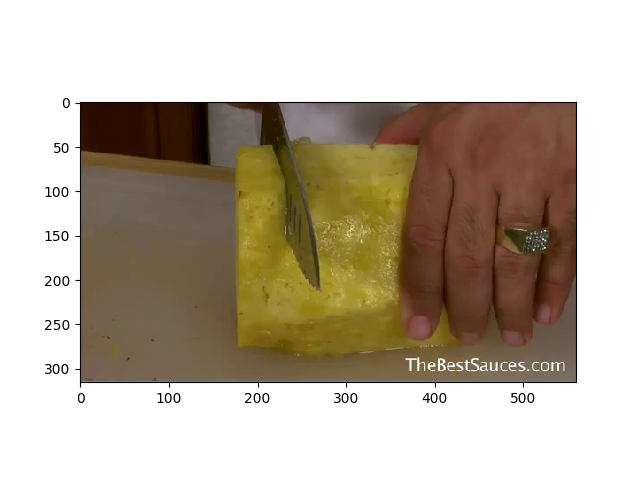

In [182]:
plt_tensor(frames_to_do / 255.)
# pass_in = frames_to_do.view(sh[0], sh[3], sh[1], sh[2]) / 255.

In [183]:
pass_in = frames_to_do.permute(0, 3, 1, 2) / 255.
# B x C x H x W
print(pass_in.shape)
print(pass_in.max())
print(pass_in.min())

torch.Size([8, 3, 316, 560])
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')


<IPython.core.display.Javascript object>


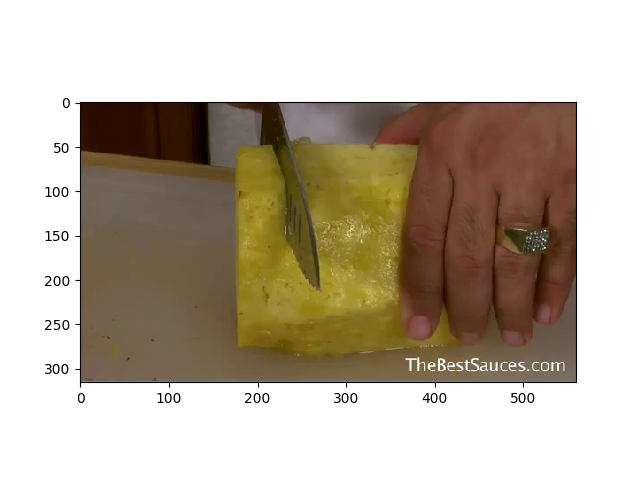

In [184]:
plt_tensor(pass_in)

In [205]:
inp = torch.nn.functional.interpolate(pass_in, size=(oh, ow), mode='bilinear', align_corners=True)

<IPython.core.display.Javascript object>


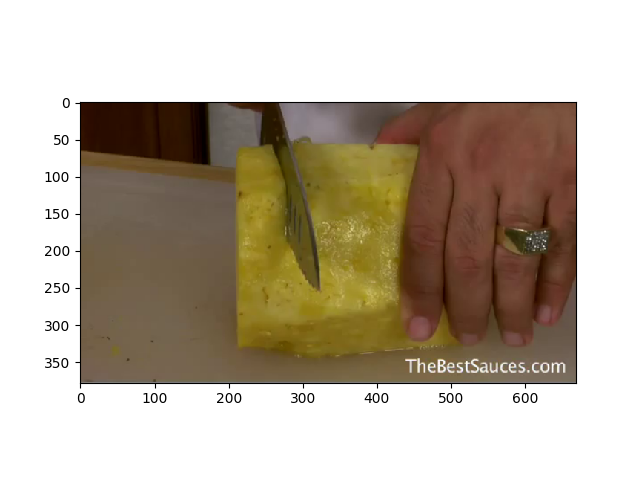

In [206]:
plt_tensor(inp)

In [156]:
# inp = torch.nn.functional.interpolate(pass_in[0], size=(ow,), mode='linear', align_corners=True)
# plt_tensor(inp.unsqueeze(0))

In [209]:
inp.shape

torch.Size([8, 3, 378, 669])

In [210]:
cropped_frames = inp[:, :, a:b, c:d]

In [211]:
cropped_frames.shape

torch.Size([8, 3, 331, 331])

<IPython.core.display.Javascript object>


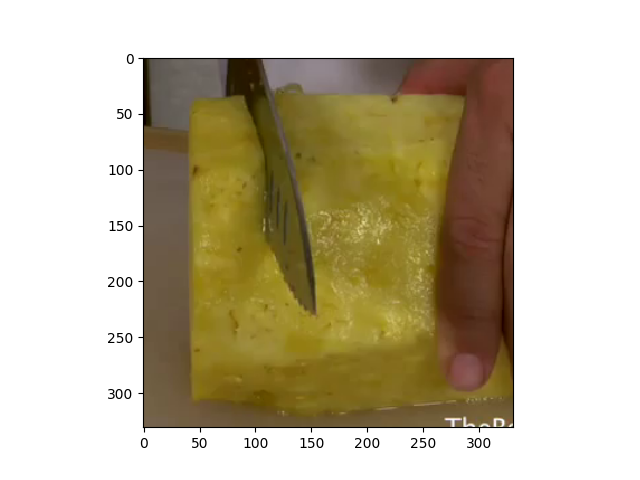

In [212]:
plt_tensor(cropped_frames)

In [213]:
for i in range(len(cropped_frames)):
    cropped_frames[i] = tf(cropped_frames[i])

print(cropped_frames.min())
print(cropped_frames.max())

tensor(-1., device='cuda:0')
tensor(0.9968, device='cuda:0')


<IPython.core.display.Javascript object>


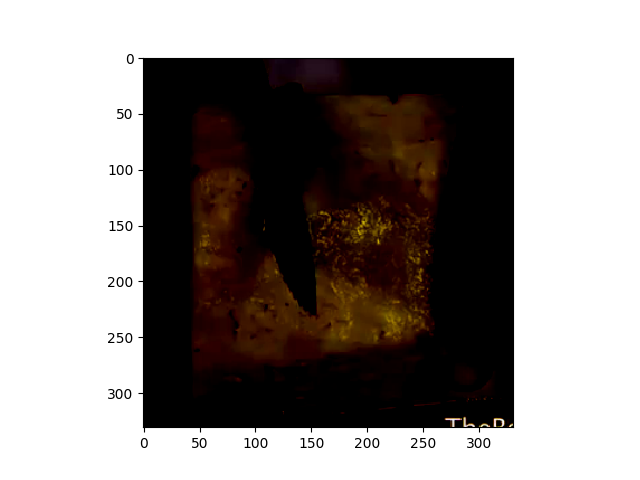

In [217]:
# The cropped and normalized frames
plt_tensor(cropped_frames)

<IPython.core.display.Javascript object>


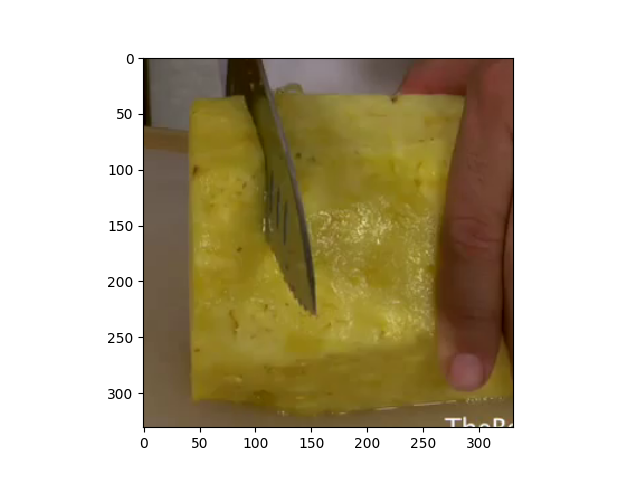

In [219]:
# Reversing the normalization
plt_tensor((cropped_frames + 1) / 2)

In [110]:
# B x C x H x W
a = torch.zeros(1, 3, 5, 6)
a[0, :, :, 3] = 1.

In [111]:
print(a)

tensor([[[[0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.]],

         [[0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.]],

         [[0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0., 0.]]]])


In [112]:
a.shape

torch.Size([1, 3, 5, 6])

<IPython.core.display.Javascript object>


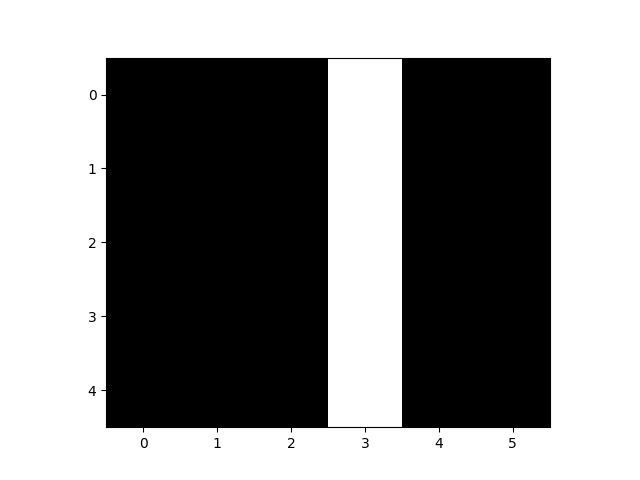

In [115]:
plt_tensor(a)

In [118]:
a[0].permute(1, 2, 0).shape

torch.Size([5, 6, 3])

<IPython.core.display.Javascript object>


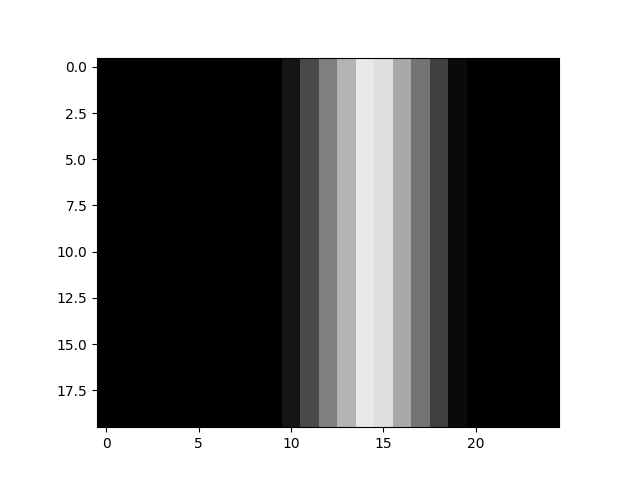

In [117]:
A = torch.nn.functional.interpolate(a, size=(20, 25), mode='bilinear', align_corners=True)
plt_tensor(A)

In [20]:
dia = torch.from_numpy(np.asarray([-1.]))
torch.sigmoid(dia) - 0.5

tensor([-0.2311], dtype=torch.float64)

In [21]:
torch.abs(torch.sigmoid(dia) - 0.5)

tensor([0.2311], dtype=torch.float64)

In [16]:
dia.tanh()

tensor([-0.7616], dtype=torch.float64)

In [17]:
torch.abs(dia.tanh())

tensor([0.7616], dtype=torch.float64)